n_sim = 1
Idle_RU: 0.39018501575683645
success_RU: 0.3286621937582596
collision_RU: 0.28115279048490394
access_STA: 0.07076365632720284
success_STA: 0.3460739869113989
collision_STA: 0.6528334254616681
Avg_Th: 0.13778122310835483
Total_Th: 17.222652888544353
Fairness: 0.7330635178834309
Avg_Delay1: 27.13160480439319
Avg_Delay2: 74.71984499668994
Th_per_STA: array shape=(125,)
R1: array shape=(67, 2)


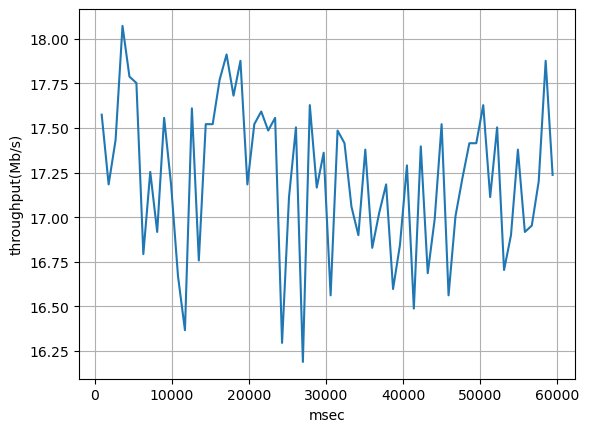

Elapsed: 4.28 sec


In [ ]:
# === RPT_Simple_UORA_split.py ===
# 원본: RPT_Simple_UORA.m 의 파이썬 포팅을 "단계별 함수"로 완전 분해
# - 로직/타이밍/식/난수/인덱싱 동일 유지
# - state S(dict) 한 곳에 모든 변수/배열 저장, step 함수들이 S를 in-place로 갱신
# - Mode_UORA=9 일 때 Tab_OCW.in 읽기 그대로 유지
# - NaN/Inf 전파(분모 0) 동작도 원본과 동일

import numpy as np
import math
import time
import matplotlib.pyplot as plt

# -------------------------
# 0) 공통 헬퍼
# -------------------------
def ru_tones_by_count(N_RU: int) -> np.ndarray:
    if N_RU == 9:
        return np.array([24]*9, dtype=float)
    elif N_RU == 8:
        return np.array([24]*7 + [48], dtype=float)
    elif N_RU == 7:
        # [24, 24, 24, 24, 24, 48, 48]
        # 5개의 RU는 26-tone RU
        return np.array([24]*5 + [48]*2, dtype=float)
    elif N_RU == 6:
        return np.array([24]*3 + [48]*3, dtype=float)
    elif N_RU == 5:
        return np.array([24] + [48]*4, dtype=float)
    elif N_RU == 4:
        return np.array([24]*4, dtype=float)
    elif N_RU == 2:
        return np.array([102,102], dtype=float)
    elif N_RU == 1:
        return np.array([234], dtype=float)
    else:
        raise RuntimeError('the value of N_RU is not supported yet!')

def nearest_index_col1(A: np.ndarray, val: float) -> int:
    # knnsearch(Tab_OCW(:,1), val) 과 동일 효과 (1열 기준 최근접)
    return int(np.argmin(np.abs(A[:,0] - val)))

# -------------------------
# 1) 사용자 설정(원본과 동일 의미)
# -------------------------
def build_config():
    C = {}
    # 시드/라벨
    C['N_SIM'] = 1
    C['List_Seed'] = np.arange(1731, 1731 + C['N_SIM'])
    C['Sim_ID'] = '2100518_TEST_02'

    # Major parameters
    C['OCWmin'] = 7    # (7 or 15)
    C['OCWmax'] = 31   # (31 or 63 or 255)
    C['Mode_UORA'] = 9

    # pattern for unassoc. STA
    C['N_unassoc_In']  = 5
    C['T_unassoc_In']  = 0.0 # sec
    C['N_unassoc_Out'] = 2
    C['T_unassoc_Out'] = 4.0 # sec
    C['N_STAs_Assoc']  = 50  # 단일 케이스

    # 옵션
    C['Opt_Observation_TH']    = 1  # per-unit_time throughput
    C['Opt_Observation_Delay'] = 1
    C['Opt_Save_Per_STA_TH']   = 1

    # PHY
    C['BW']   = 20  # MHz (실제 수식엔 직접 사용 안 함)
    C['N_ss'] = 1
    C['N_bp'] = np.array([1,2,2,4,4,6,6,6,8,8,10,10], dtype=float) # per subcarrier
    C['Rcod'] = np.array([1/2,1/2,3/4,1/2,3/4,2/3,3/4,5/6,3/4,5/6,3/4,5/6], dtype=float)
    C['T_dft'] = 12.8e-6
    C['T_gi']  = 1.6e-6

    # RU 구조
    C['N_RU'] = 9
    C['N_RA_RU_0']    = 8  # associated STAs용 RA-RU 수
    C['N_RA_RU_2045'] = C['N_RU'] - C['N_RA_RU_0']
    C['Opt_Random_N_RA_RU_0'] = 0

    # 시뮬레이션 슬롯 수
    C['N_slot_total'] = 1111112*6
    return C

# -------------------------
# 2) 초기화(원본 run_once 초반부를 분해)
# -------------------------
def init_sim(C, seed: int):
    S = {}
    S['rng'] = np.random.default_rng(seed)

    # 관측 옵션
    if C['Opt_Observation_TH']:
        S['Observation_Period'] = 100000  # slots
        S['log_slot_time_SUC'] = [0]      # 누적 슬롯 구간 길이
        S['log_SUC'] = [0]                # 누적 성공 변화량
        S['Next_Observation_Time_TH'] = S['Observation_Period']
    else:
        S['Observation_Period'] = None
        S['log_slot_time_SUC'] = []
        S['log_SUC'] = []
        S['Next_Observation_Time_TH'] = None

    if C['Opt_Observation_Delay']:
        S['Observation_Period_Delay'] = 1000
        S['Next_Observation_Time_Delay'] = S['Observation_Period_Delay']
    else:
        S['Observation_Period_Delay'] = None
        S['Next_Observation_Time_Delay'] = None

    # Per-STA TH 저장 행렬(옵션)
    if C['Opt_Save_Per_STA_TH']:
        S['Result_Per_TH'] = np.full((int(C['N_STAs_Assoc']), 1), np.nan, dtype=float)
    else:
        S['Result_Per_TH'] = None

    # RU AID 설정
    if C['N_RA_RU_0'] + C['N_RA_RU_2045'] != C['N_RU']:
        raise RuntimeError('Wrong RA-RU configuration!')

    S['RU_AID'] = np.zeros(C['N_RU'], dtype=int)
    S['RU_AID'][:C['N_RA_RU_0']] = 0
    S['RU_AID'][C['N_RA_RU_0']:] = 2045

    # RU별 유효 서브캐리어 수
    S['N_sd'] = ru_tones_by_count(C['N_RU'])
    if C['N_RU'] != len(S['N_sd']):
        raise RuntimeError('configuration is invalid!')

    # MAC/PHY 기본값
    S['N_STAs_existing'] = int(C['N_STAs_Assoc'])
    S['N_STA'] = S['N_STAs_existing'] + int(C['N_unassoc_In'])

    S['CWmin'] = C['OCWmin']
    S['CWmax'] = C['OCWmax']

    S['Common_MCS'] = 5
    S['MCS'] = np.full(S['N_STA'], S['Common_MCS'], dtype=int)

    # Basic data rate (Assoc req에 사용, MCS0 기준)
    S['Basic_Data_Rate'] = (S['N_sd'] * C['N_bp'][0] * C['Rcod'][0] * C['N_ss']) / (C['T_dft'] + C['T_gi'])

    S['U_slot'] = 9e-6
    S['SIFS']   = 16e-6

    # 길이/시간
    S['L_MPDU']   = np.full(S['N_STA'], 2000.0, dtype=float)  # Byte
    S['L_PHY']    = 40e-6
    S['L_Trigger']= 100e-6
    S['L_BACK']   = 68e-6

    # Assoc req 길이 슬롯 단위
    S['L_Assoc_Req'] = 38.0
    S['L_Assoc_Req_in_Slot'] = int(np.ceil( (S['L_PHY'] + 8*S['L_Assoc_Req']/S['Basic_Data_Rate'][0]) / S['U_slot'] ))

    # UORA 모드별 파라미터
    S['alpha_g'] = None
    if C['Mode_UORA'] == 2:
        S['alpha_g'] = 1.5
    elif C['Mode_UORA'] == 3:
        S['alpha_g'] = 1.0
        S['Max_alpha'] = 2.0
        S['Min_alpha'] = 0.1
        S['Inc'] = 0.1
        S['Dec'] = 0.1
    elif C['Mode_UORA'] in (4,5,6,7,8):
        S['Init_alpha'] = 1.0
        S['alpha'] = np.full(S['N_STA'], S['Init_alpha'], dtype=float)
        S['Max_alpha'] = 2.0
        S['Min_alpha'] = 0.1
        S['Inc'] = 0.1
        S['Dec'] = 0.1
        # Selfish/UORA_STD 비활성(원본과 동일 전제)
        if C['Mode_UORA'] in (5,6,7,8):
            S['Succ'] = np.zeros((S['N_STA'],2), dtype=float)  # [success_streak, collision_streak]
        S['Opt_Observation_Alpha'] = 1
        S['Target_STA'] = 1
        S['Target_N_STAs'] = [10,20,100]
        S['log_alpha'] = []
        S['log_slot_time'] = []
    elif C['Mode_UORA'] == 9:
        # Tab_OCW.in 읽기
        S['Tab_OCW'] = np.loadtxt('Tab_OCW.in')
    else:
        pass

    # BEB/XIXD
    S['Mode_OBO_BEB']  = 1
    S['Mode_OBO_XIXD'] = 0
    if S['Mode_OBO_BEB'] and S['Mode_OBO_XIXD']:
        raise RuntimeError('Mode is collided!')

    # 시간(초→슬롯)
    S['T_unassoc_In_slots']  = int(np.ceil(C['T_unassoc_In']/S['U_slot']))
    S['T_unassoc_Out_slots'] = int(np.ceil(C['T_unassoc_Out']/S['U_slot']))
    S['T_Period_InOut'] = S['T_unassoc_In_slots'] + S['T_unassoc_Out_slots']

    S['Next_T_unassoc_Out'] = S['T_unassoc_Out_slots']
    S['Next_T_unassoc_In']  = S['Next_T_unassoc_Out'] + S['T_unassoc_In_slots']

    # 결과 테이블
    S['Sim_Rst']    = np.zeros((S['N_STA'],4), dtype=float)   # [Access, Success, Collisions, sum(n_tf)]
    S['Sim_Rst_RU'] = np.zeros((C['N_RU'],3), dtype=float)    # [IDLE, SUCCESS, COLLISION]
    S['N_TF'] = 0
    S['n_tf'] = np.zeros(S['N_STA'], dtype=float)

    S['Observation_N_assoc'] = []

    # 초기 CW/Type/OBO
    S['STA_CWmin'] = np.full(S['N_STA'], S['CWmin'], dtype=float)
    S['STA_CWmax'] = np.full(S['N_STA'], S['CWmax'], dtype=float)
    S['STA_CW']    = S['STA_CWmin'].copy()

    S['STA_Type'] = np.zeros(S['N_STA'], dtype=int)
    S['STA_Type'][:S['N_STAs_existing']] = 1   # 기존 assoc
    S['STA_Type'][S['N_STAs_existing']:] = 0   # 새 unassoc

    S['STA_Assoc_Delay'] = np.zeros((S['N_STA'],3), dtype=float)
    S['STA_Assoc_Delay'][:S['N_STAs_existing'], :] = np.nan
    S['STA_Assoc_Delay'][S['N_STAs_existing']:,  :] = 0.0

    S['STA_OBO'] = np.floor(S['STA_CW'] * S['rng'].random(S['N_STA']))
    S['STA_Assigned_RU'] = np.zeros(S['N_STA'], dtype=int)

    S['log_OCW_assoc']   = np.array([[S['CWmin'], S['CWmin']]], dtype=float)
    S['log_OCW_unassoc'] = np.array([[S['CWmin'], S['CWmin']]], dtype=float)

    # 루프 인덱스
    S['i'] = 1
    S['start_t'] = time.time()
    return S

# -------------------------
# 3) Step 함수들
# -------------------------
def step_in_out(C, S):
    rng = S['rng']
    # 입장
    if S['Next_T_unassoc_In'] <= S['i'] and C['N_unassoc_In'] > 0:
        STA_ID_Disable = np.where(S['STA_Type'] == -1)[0]
        if len(STA_ID_Disable) == C['N_unassoc_In']:
            S['STA_Type'][STA_ID_Disable] = 0
            S['Next_T_unassoc_In'] = S['i'] + S['T_Period_InOut']
        else:
            old_N = S['N_STA']
            S['N_STA'] += int(C['N_unassoc_In'])
            S['Next_T_unassoc_In'] = S['i'] + S['T_Period_InOut']

            S['STA_Type'] = np.concatenate([S['STA_Type'], np.zeros(int(C['N_unassoc_In']), dtype=int)])
            # L_MPDU는 원본에서 resize; 여기선 concat로 동일 효과
            S['L_MPDU'] = np.concatenate([S['L_MPDU'], np.full(int(C['N_unassoc_In']), 2000.0)])
            S['MCS'] = np.concatenate([S['MCS'], np.full(int(C['N_unassoc_In']), S['Common_MCS'], dtype=int)])
            S['STA_CWmin'] = np.concatenate([S['STA_CWmin'], np.full(int(C['N_unassoc_In']), S['CWmin'], dtype=float)])
            S['STA_CWmax'] = np.concatenate([S['STA_CWmax'], np.full(int(C['N_unassoc_In']), S['CWmax'], dtype=float)])
            S['STA_CW']    = np.concatenate([S['STA_CW'],    np.full(int(C['N_unassoc_In']), S['CWmin'], dtype=float)])
            S['STA_OBO']   = np.concatenate([S['STA_OBO'],   np.floor(S['CWmin'] * rng.random(int(C['N_unassoc_In'])))])
            S['STA_Assigned_RU'] = np.concatenate([S['STA_Assigned_RU'], np.zeros(int(C['N_unassoc_In']), dtype=int)])
            add_delay = np.zeros((int(C['N_unassoc_In']),3), dtype=float)
            add_delay[:,0] = (S['Next_T_unassoc_In'] - S['T_unassoc_In_slots'])
            S['STA_Assoc_Delay'] = np.vstack([S['STA_Assoc_Delay'], add_delay])
            S['Sim_Rst'] = np.vstack([S['Sim_Rst'], np.zeros((int(C['N_unassoc_In']),4), dtype=float)])
            S['n_tf'] = np.concatenate([S['n_tf'], np.zeros(int(C['N_unassoc_In']), dtype=float)])

            if C['Mode_UORA'] in (4,5,6,7,8):
                S['alpha'] = np.concatenate([S['alpha'], np.full(int(C['N_unassoc_In']), S['Init_alpha'], dtype=float)])
                if C['Mode_UORA'] in (5,6,7,8):
                    S['Succ'] = np.vstack([S['Succ'], np.zeros((int(C['N_unassoc_In']),2), dtype=float)])

    # 퇴장
    if S['Next_T_unassoc_Out'] <= S['i'] and C['N_unassoc_Out'] > 0:
        STA_ID_Assoc = np.where(S['STA_Type'] == 1)[0]
        Disable_STA_ID = []
        while len(Disable_STA_ID) < int(C['N_unassoc_Out']) and len(STA_ID_Assoc) > 0:
            pick = S['rng'].choice(STA_ID_Assoc)
            if pick not in Disable_STA_ID:
                Disable_STA_ID.append(pick)
                S['STA_Type'][pick] = -1
        S['Next_T_unassoc_Out'] = S['i'] + S['T_Period_InOut']

def step_obo_decrement(C, S):
    rng = S['rng']
    STA_ID_Unassoc = np.where(S['STA_Type'] == 0)[0]
    STA_ID_Assoc   = np.where(S['STA_Type'] == 1)[0]

    if C['Mode_UORA'] in (0,9):
        if C['Opt_Random_N_RA_RU_0']:
            N_Random_RA_RU_0 = int(math.ceil(rng.random()*C['N_RA_RU_0']))
            if STA_ID_Unassoc.size:
                S['STA_OBO'][STA_ID_Unassoc] -= C['N_RA_RU_2045']
            if STA_ID_Assoc.size:
                S['STA_OBO'][STA_ID_Assoc]   -= N_Random_RA_RU_0
        else:
            if STA_ID_Unassoc.size:
                S['STA_OBO'][STA_ID_Unassoc] -= C['N_RA_RU_2045']
            if STA_ID_Assoc.size:
                S['STA_OBO'][STA_ID_Assoc]   -= C['N_RA_RU_0']

    elif C['Mode_UORA'] == 1:
        raise RuntimeError('Mode_UORA == 1 not supported in provided script')

    elif C['Mode_UORA'] == 2:
        S['STA_OBO'] -= S['alpha_g'] * C['N_RU']
    elif C['Mode_UORA'] == 3:
        S['STA_OBO'] -= S['alpha_g'] * C['N_RU']
    elif C['Mode_UORA'] in (4,5,6,7,8):
        if STA_ID_Unassoc.size:
            S['STA_OBO'][STA_ID_Unassoc] -= S['alpha'][STA_ID_Unassoc] * C['N_RA_RU_2045']
        if STA_ID_Assoc.size:
            NR = C['N_RA_RU_0']  # 랜덤옵션 있어도 원본은 직전 값/동일
            S['STA_OBO'][STA_ID_Assoc] -= S['alpha'][STA_ID_Assoc] * NR

        if 'Opt_Observation_Alpha' in S and S['N_STA'] in [10,20,100]:
            S['log_slot_time'].append(S['i'])
            if S['N_STA'] >= 1:
                S['log_alpha'].append(S['alpha'][0])

def step_tf_and_ru_assign(C, S):
    rng = S['rng']
    STA_ID_Assoc   = np.where(S['STA_Type'] == 1)[0]
    STA_ID_TX = np.where(S['STA_OBO'] <= 0)[0]
    STA_ID_TX_Unassoc = np.setdiff1d(STA_ID_TX, STA_ID_Assoc, assume_unique=False)
    STA_ID_TX_Assoc   = np.setdiff1d(STA_ID_TX, STA_ID_TX_Unassoc, assume_unique=False)

    if STA_ID_TX_Assoc.size:
        if C['Opt_Random_N_RA_RU_0']:
            N_Random_RA_RU_0 = max(1, int(math.ceil(rng.random()*C['N_RA_RU_0'])))
            S['STA_Assigned_RU'][STA_ID_TX_Assoc] = rng.integers(1, N_Random_RA_RU_0+1, size=STA_ID_TX_Assoc.size)
        else:
            S['STA_Assigned_RU'][STA_ID_TX_Assoc] = rng.integers(1, C['N_RA_RU_0']+1, size=STA_ID_TX_Assoc.size)
    if STA_ID_TX_Unassoc.size:
        S['STA_Assigned_RU'][STA_ID_TX_Unassoc] = rng.integers(C['N_RA_RU_0']+1, C['N_RU']+1, size=STA_ID_TX_Unassoc.size)

    if STA_ID_TX.size:
        S['N_TF'] += 1
        S['n_tf'] += 1

    return STA_ID_TX, STA_ID_TX_Unassoc, STA_ID_TX_Assoc

def step_ru_outcomes(C, S, STA_ID_TX):
    STA_ID_SUC = []
    STA_ID_COL = []

    for j in range(1, C['N_RU']+1):
        ids = np.where(S['STA_Assigned_RU'] == j)[0]
        if ids.size == 0:
            S['Sim_Rst_RU'][j-1, 1-1] += 1  # IDLE
            continue

        S['Sim_Rst'][ids, 0] += 1  # Access

        if ids.size > 1:
            # Collision
            S['Sim_Rst'][ids, 2] += 1
            S['Sim_Rst_RU'][j-1, 3-1] += 1
            STA_ID_COL.extend(ids.tolist())

            # BEB / Mode9
            if S['Mode_OBO_BEB']:
                if C['Mode_UORA'] == 9:
                    if S['RU_AID'][j-1] == 0 and (C['N_unassoc_In'] > 0 or C['N_unassoc_Out'] > 0):
                        assoc_cnt = int(np.sum(S['STA_Type'] == 1))
                        r = nearest_index_col1(S['Tab_OCW'], assoc_cnt)
                        col = min((C['N_RA_RU_0'] + 1), S['Tab_OCW'].shape[1]-1)
                        newcw = S['Tab_OCW'][r, col]
                        S['STA_CW'][ids] = newcw
                        if 1 in ids:
                            S['log_OCW_assoc'] = np.vstack([S['log_OCW_assoc'], [S['i'], newcw]])
                    elif S['RU_AID'][j-1] == 2045 and (C['N_unassoc_In'] > 0 or C['N_unassoc_Out'] > 0):
                        unassoc_cnt = int(np.sum(S['STA_Type'] == 0))
                        r = nearest_index_col1(S['Tab_OCW'], unassoc_cnt)
                        col = min((C['N_RA_RU_2045'] + 1), S['Tab_OCW'].shape[1]-1)
                        newcw = S['Tab_OCW'][r, col]
                        S['STA_CW'][ids] = newcw
                        S['log_OCW_unassoc'] = np.vstack([S['log_OCW_unassoc'], [S['i'], newcw]])
                else:
                    # 기본 BEB
                    S['STA_CW'][ids] = (S['STA_CW'][ids] + 1.0) * 2.0 - 1.0
                    over = np.where(S['STA_CW'][ids] >= S['STA_CWmax'][ids])[0]
                    if over.size:
                        S['STA_CW'][ids[over]] = S['STA_CWmax'][ids[over]]

            # alpha 조정
            if C['Mode_UORA'] == 3:
                S['alpha_g'] = max(S['Min_alpha'], S['alpha_g'] - S['Dec'])
            elif C['Mode_UORA'] == 4:
                S['alpha'][ids] = np.maximum(S['Min_alpha'], S['alpha'][ids] - S['Dec'])
            elif C['Mode_UORA'] == 5:
                S['Succ'][ids,1] += 1
                S['Succ'][ids,0]  = 0
                S['alpha'][ids] = np.maximum(S['Min_alpha'], S['alpha'][ids] - S['Dec'] * (2.0 ** (S['Succ'][ids,1]-1)))
            elif C['Mode_UORA'] == 6:
                for kk in ids:
                    S['Succ'][kk,1] += 1
                    if S['Succ'][kk,0] > 0:
                        S['alpha'][kk] = S['Init_alpha']
                    else:
                        S['alpha'][kk] = max(S['Min_alpha'], S['alpha'][kk] - S['Dec'])
                    S['Succ'][kk,0] = 0
            elif C['Mode_UORA'] in (7,8):
                S['Succ'][ids,1] += 1
                S['Succ'][ids,0]  = 0
                if C['Mode_UORA'] == 7:
                    S['alpha'][ids] = np.maximum(S['Min_alpha'], S['alpha'][ids] - S['Dec'])
                else:
                    S['alpha'][ids] = np.maximum(S['Min_alpha'], S['alpha'][ids] - S['Dec'] * (2.0 ** (S['Succ'][ids,1]-1)))

        else:
            # Success
            one = ids[0]
            if S['STA_Type'][one] == 1:
                S['Sim_Rst'][one, 1] += 1
            S['Sim_Rst_RU'][j-1, 2-1] += 1
            S['Sim_Rst'][one, 3] += S['n_tf'][one]
            S['n_tf'][one] = 0
            STA_ID_SUC.append(one)

            # 성공 시 CW 갱신
            if S['Mode_OBO_BEB']:
                if C['Mode_UORA'] == 9:
                    if S['RU_AID'][j-1] == 0 and (C['N_unassoc_In'] > 0 or C['N_unassoc_Out'] > 0):
                        assoc_cnt = int(np.sum(S['STA_Type'] == 1))
                        r = nearest_index_col1(S['Tab_OCW'], assoc_cnt)
                        col = min((C['N_RA_RU_0'] + 1), S['Tab_OCW'].shape[1]-1)
                        newcw = S['Tab_OCW'][r, col]
                        S['STA_CW'][one] = newcw
                        if one == 1:
                            S['log_OCW_assoc'] = np.vstack([S['log_OCW_assoc'], [S['i'], newcw]])
                    elif S['RU_AID'][j-1] == 2045 and (C['N_unassoc_In'] > 0 or C['N_unassoc_Out'] > 0):
                        unassoc_cnt = int(np.sum(S['STA_Type'] == 0))
                        r = nearest_index_col1(S['Tab_OCW'], unassoc_cnt)
                        col = min((C['N_RA_RU_2045'] + 1), S['Tab_OCW'].shape[1]-1)
                        newcw = S['Tab_OCW'][r, col]
                        S['STA_CW'][one] = newcw
                        S['log_OCW_unassoc'] = np.vstack([S['log_OCW_unassoc'], [S['i'], newcw]])
                else:
                    S['STA_CW'][one] = S['STA_CWmin'][one]

            # alpha 증가
            if C['Mode_UORA'] == 3:
                S['alpha_g'] = min(S['Max_alpha'], S['alpha_g'] + S['Inc'])
            elif C['Mode_UORA'] == 4:
                S['alpha'][one] = min(S['Max_alpha'], S['alpha'][one] + S['Inc'])
            elif C['Mode_UORA'] == 5:
                S['Succ'][one,0] += 1
                S['Succ'][one,1]  = 0
                S['alpha'][one] = min(S['Max_alpha'], S['alpha'][one] + S['Inc'] * (2.0 ** (S['Succ'][one,0]-1)))
            elif C['Mode_UORA'] == 6:
                S['Succ'][one,0] += 1
                if S['Succ'][one,1] > 0:
                    S['alpha'][one] = S['Init_alpha'] + S['Inc']
                else:
                    S['alpha'][one] = min(S['Max_alpha'], S['alpha'][one] + S['Inc'])
                S['Succ'][one,1] = 0
            elif C['Mode_UORA'] in (7,8):
                S['Succ'][one,0] += 1
                S['Succ'][one,1]  = 0
                if C['Mode_UORA'] == 7:
                    S['alpha'][one] = min(S['Max_alpha'], S['alpha'][one] + S['Inc'] * (2.0 ** (S['Succ'][one,0]-1)))
                else:
                    S['alpha'][one] = min(S['Max_alpha'], S['alpha'][one] + S['Inc'])

    return np.array(STA_ID_SUC, dtype=int), np.array(STA_ID_COL, dtype=int)

def step_time_and_assoc_success(C, S, STA_ID_TX, STA_ID_SUC):
    if STA_ID_TX.size:
        # 데이터 레이트 계산
        data_rates = np.zeros(STA_ID_TX.size, dtype=float)
        for idx_k, ksta in enumerate(STA_ID_TX):
            ru = S['STA_Assigned_RU'][ksta]
            ru = max(1, min(C['N_RU'], ru))
            mcs = S['MCS'][ksta]
            data_rates[idx_k] = (S['N_sd'][ru-1] * C['N_bp'][mcs] * C['Rcod'][mcs] * C['N_ss']) / (C['T_dft'] + C['T_gi'])

        STA_ID_assoc_req = STA_ID_TX[S['STA_Type'][STA_ID_TX] == 0]
        STA_ID_Data_TX   = STA_ID_TX[S['STA_Type'][STA_ID_TX] == 1]

        # 시간 소모
        if STA_ID_assoc_req.size and STA_ID_Data_TX.size:
            dur = int( np.max( np.ceil( (S['L_PHY'] + (8*S['L_MPDU'][STA_ID_TX]/data_rates)) / S['U_slot'] ) ) ) \
                  + int( np.ceil( (2*S['L_PHY'] + S['L_BACK'] + S['L_Trigger'] + 3*S['SIFS']) / S['U_slot']) )
            S['i'] += dur
        elif STA_ID_assoc_req.size:
            dur = int(S['L_Assoc_Req_in_Slot']) \
                  + int( np.ceil( (2*S['L_PHY'] + S['L_BACK'] + S['L_Trigger'] + 3*S['SIFS']) / S['U_slot'] ) )
            S['i'] += dur
        elif STA_ID_Data_TX.size:
            dur = int( np.max( np.ceil( (S['L_PHY'] + (8*S['L_MPDU'][STA_ID_TX]/data_rates)) / S['U_slot'] ) ) ) \
                  + int( np.ceil( (2*S['L_PHY'] + S['L_BACK'] + S['L_Trigger'] + 3*S['SIFS']) / S['U_slot']) )
            S['i'] += dur
        else:
            raise RuntimeError('unexpected situation!')

        # Assoc 성공 처리
        for ksta in STA_ID_assoc_req:
            if ksta in set(STA_ID_SUC.tolist()):
                S['STA_Type'][ksta] = 1
                ack_time = S['i'] - int(np.ceil((2*S['L_PHY'] + S['L_BACK'] + S['L_Trigger'] + 3*S['SIFS']) / S['U_slot']))
                S['STA_Assoc_Delay'][ksta,1] = ack_time
                S['STA_Assoc_Delay'][ksta,2] = S['STA_Assoc_Delay'][ksta,1] - S['STA_Assoc_Delay'][ksta,0]

        # reset
        S['STA_Assigned_RU'][:] = 0
        TF_happened = True
    else:
        S['i'] += 1
        TF_happened = False

    # 관측 N_assoc
    S['Observation_N_assoc'].append([S['i'],
                                    float(np.sum(S['STA_Type'] == 0)),
                                    float(np.sum(S['STA_Type'] == 1))])
    return TF_happened

def step_observation_and_tail(C, S, TF_happened: bool):
    # Throughput 관측 업데이트
    if C['Opt_Observation_TH'] and (S['Next_Observation_Time_TH'] is not None) and (S['Next_Observation_Time_TH'] <= S['i']):
        S['log_slot_time_SUC'].append(S['i'] - sum(S['log_slot_time_SUC']))
        S['log_SUC'].append( float(np.sum(S['Sim_Rst'][:,1])) - sum(S['log_SUC']) )
        S['Next_Observation_Time_TH'] += S['Observation_Period']

    # 루프 말미: 랜덤 RA-RU & Mode9 CW 재적용
    if C['Opt_Random_N_RA_RU_0']:
        N_Random_RA_RU_0 = int(math.ceil(S['rng'].random()*C['N_RA_RU_0']))
        if C['Mode_UORA'] == 9 and S['N_STAs_existing'] > 0:
            r = nearest_index_col1(S['Tab_OCW'], S['N_STAs_existing'])
            col = min((N_Random_RA_RU_0 + 1), S['Tab_OCW'].shape[1]-1)
            newcw = S['Tab_OCW'][r, col]
            S['STA_CW'][:S['N_STAs_existing']] = newcw

    # TF 있었던 STA들의 OBO 재시작
    if TF_happened:
        STA_ID_TX = np.where(S['STA_OBO'] <= 0)[0]
        if STA_ID_TX.size:
            S['STA_OBO'][STA_ID_TX] = np.floor(S['STA_CW'][STA_ID_TX] * S['rng'].random(STA_ID_TX.size))

# -------------------------
# 4) 한 슬롯 실행
# -------------------------
def run_one_slot(C, S):
    step_in_out(C, S)
    step_obo_decrement(C, S)
    STA_ID_TX, _, _ = step_tf_and_ru_assign(C, S)
    STA_ID_SUC, STA_ID_COL = step_ru_outcomes(C, S, STA_ID_TX)
    TF_happened = step_time_and_assoc_success(C, S, STA_ID_TX, STA_ID_SUC)
    step_observation_and_tail(C, S, TF_happened)

# -------------------------
# 5) 지표 계산/플롯(원본 식 그대로)
# -------------------------
def compute_metrics_and_plot(C, S):
    Idle_RU      = np.mean(S['Sim_Rst_RU'][:,0] / np.sum(S['Sim_Rst_RU'], axis=1))
    success_RU   = np.mean(S['Sim_Rst_RU'][:,1] / np.sum(S['Sim_Rst_RU'], axis=1))
    collision_RU = np.mean(S['Sim_Rst_RU'][:,2] / np.sum(S['Sim_Rst_RU'], axis=1))

    access_STA   = np.mean(S['Sim_Rst'][:,0] / max(S['N_TF'],1))
    success_STA  = np.mean(S['Sim_Rst'][:,1] / S['Sim_Rst'][:,0])   # NaN 전파 허용
    collision_STA= np.mean(S['Sim_Rst'][:,2] / S['Sim_Rst'][:,0])   # NaN 전파 허용

    # per-STA throughput (Mbps)
    Th_per_STA = S['Sim_Rst'][:,1] * (8*S['L_MPDU']) / (C['N_slot_total'] * S['U_slot']) * 1e-6
    Avg_Th   = float(np.mean(Th_per_STA))
    Total_Th = float(np.sum(Th_per_STA))
    Fairness = float( (np.sum(Th_per_STA)**2) / (S['N_STA'] * np.sum(Th_per_STA**2)) )

    Avg_Delay1 = float(np.mean(S['Sim_Rst'][:,3] / S['Sim_Rst'][:,1]))  # TF count 평균

    # Avg_Delay2 (msec)
    if C['N_RU'] == 1:
        Data_Rate_ref = (S['N_sd'][0] * C['N_bp'][S['MCS'][0]] * C['Rcod'][S['MCS'][0]] * C['N_ss']) / (C['T_dft'] + C['T_gi'])
    else:
        Data_Rate_ref = (S['N_sd'][0] * C['N_bp'][S['MCS'][0]] * C['Rcod'][S['MCS'][0]] * C['N_ss']) / (C['T_dft'] + C['T_gi'])

    term_A = int(np.ceil((S['L_PHY'] + S['L_Trigger'] + S['SIFS']) / S['U_slot']))
    term_B = int(np.ceil( (S['L_PHY'] + np.max(8*S['L_MPDU'] / Data_Rate_ref)) / S['U_slot'] ))
    term_C = int(np.ceil((S['L_PHY'] + S['L_BACK'] + 2*S['SIFS']) / S['U_slot']))
    const_term = term_A + term_B + term_C
    tail_term  = term_C

    Avg_Delay2 = float( np.mean( (S['Sim_Rst'][:,3] * const_term - tail_term) / S['Sim_Rst'][:,1] ) * S['U_slot'] * 1e3 )

    # Throughput 관측 곡선 (R1)
    if C['Opt_Observation_TH'] and len(S['log_slot_time_SUC'])>0:
        with np.errstate(divide='ignore', invalid='ignore'):
            times_ms = np.cumsum(S['log_slot_time_SUC']) * (S['U_slot']*1e3)
            th_vals  = (8*S['L_MPDU'][0]) * np.array(S['log_SUC'], dtype=float) / (np.array(S['log_slot_time_SUC'], dtype=float)*S['U_slot']) * 1e-6
        R1 = np.column_stack([times_ms, th_vals])
    else:
        R1 = np.zeros((0,2), dtype=float)

    # 출력
    print(f"Idle_RU: {Idle_RU}")
    print(f"success_RU: {success_RU}")
    print(f"collision_RU: {collision_RU}")
    print(f"access_STA: {access_STA}")
    print(f"success_STA: {success_STA}")
    print(f"collision_STA: {collision_STA}")
    print(f"Avg_Th: {Avg_Th}")
    print(f"Total_Th: {Total_Th}")
    print(f"Fairness: {Fairness}")
    print(f"Avg_Delay1: {Avg_Delay1}")
    print(f"Avg_Delay2: {Avg_Delay2}")
    print(f"Th_per_STA: array shape={Th_per_STA.shape}")
    print(f"R1: array shape={R1.shape}")

    # 플롯(원본 figure)
    if C['Opt_Observation_TH'] and R1.size:
        plt.figure()
        plt.plot(R1[:,0], R1[:,1])
        plt.grid(True)
        plt.xlabel('msec'); plt.ylabel('throughput(Mb/s)')
        plt.show()

    RESULTS_SUMMARY = np.array([[access_STA, success_STA, collision_STA, Total_Th, Fairness]])
    return {
        'Idle_RU': Idle_RU,
        'success_RU': success_RU,
        'collision_RU': collision_RU,
        'access_STA': access_STA,
        'success_STA': success_STA,
        'collision_STA': collision_STA,
        'Avg_Th': Avg_Th,
        'Total_Th': Total_Th,
        'Fairness': Fairness,
        'Avg_Delay1': Avg_Delay1,
        'Avg_Delay2': Avg_Delay2,
        'Th_per_STA': Th_per_STA,
        'R1': R1,
        'RESULTS_SUMMARY': RESULTS_SUMMARY,
    }

# -------------------------
# 6) 전체 시뮬레이션(run_once 대체)
# -------------------------
def run_once_split(C, seed: int):
    S = init_sim(C, seed)
    while S['i'] <= C['N_slot_total']:
        run_one_slot(C, S)
    out = compute_metrics_and_plot(C, S)
    return out

# -------------------------
# 7) 실행부
# -------------------------
if __name__ == "__main__":
    C = build_config()
    t0 = time.time()
    for n_sim in range(C['N_SIM']):
        print('n_sim =', n_sim+1)
        out = run_once_split(C, C['List_Seed'][n_sim])
    print('Elapsed: %.2f sec' % (time.time()-t0))
